In [1]:
from fastai.vision.data import *
from fastai.vision import *
from PIL import Image
from pathlib import Path
import numpy as np

In [5]:
path_data = Path('training/')

path_lbl = path_data/'croppedLabels'
path_img = path_data/'croppedImages'

# get images and labels filenames
img_names = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

print(len(img_names), len(lbl_names))

6250 6250


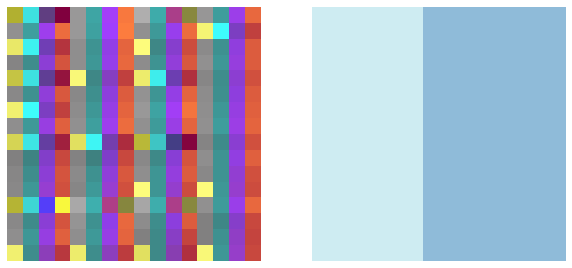

In [7]:
import matplotlib.pyplot as plt

def get_lbl_fn(img_fn: Path):  
  
    img_name = img_fn.name
    lbl_name = img_name

    return img_fn.parent.parent/('croppedLabels/' + lbl_name)

fname = Path('training/croppedImages/satImage_2_crop_2.png')

img = open_image(fname)
mask = open_mask(get_lbl_fn(fname))

fig, ax = plt.subplots(1,2, figsize=(10,6))

img.show(ax[0])
mask.show(ax[1])

In [8]:
patch_shape = 16
print(path_img)

training/croppedImages


In [9]:
# Classes for segmentation with 0,255 labels:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

bs = 4

print(f'Batch size:{bs}')
print(f'Patch shape:{patch_shape}')

src = (SegItemListCustom.from_folder(
    path_img).split_by_rand_pct().label_from_func(
        lambda x: path_lbl / x.relative_to(path_img), classes=['rest',
                                                               'road']))
data = (src.transform(get_transforms(flip_vert=True),
                      size=patch_shape,
                      tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))
data

Batch size:4
Patch shape:16


ImageDataBunch;

Train: LabelList (5000 items)
x: SegItemListCustom
Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16)
y: SegLabelListCustom
ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16)
Path: training/croppedImages;

Valid: LabelList (1250 items)
x: SegItemListCustom
Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16)
y: SegLabelListCustom
ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16),ImageSegment (1, 16, 16)
Path: training/croppedImages;

Test: None

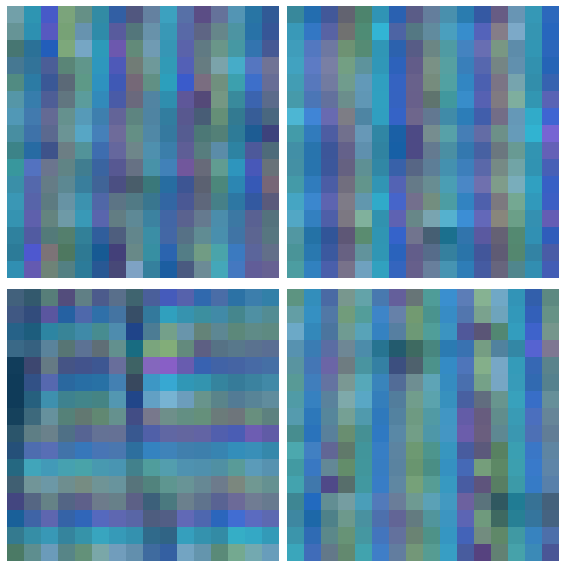

In [10]:
data.show_batch(2)

In [11]:
# create a simple metric to verify the results
def acc_metric(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

# weight decay
wd = 1e-2
#learning rate
lr=1e-3

# load the model, according to the data parameters (resolution, for example)
learn = unet_learner(data, models.resnet34, metrics=acc_metric, wd=wd)

#train the model with 3 epochs
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,acc_metric,time
0,0.420379,0.457365,0.842256,00:46
1,0.439025,0.420113,0.842256,00:46
2,0.468055,0.491478,0.842256,00:45


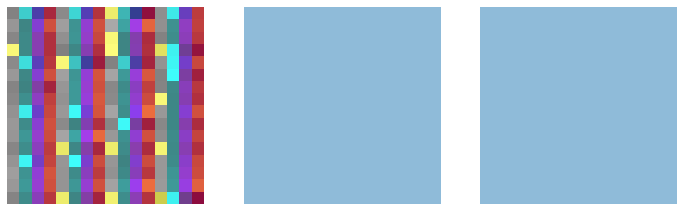

In [12]:
learn.save('road_Resnet34')

# select one image from the validation dataset
img = learn.data.valid_ds.x[22]
mask = learn.data.valid_ds.y[22]
pred = learn.predict(img)[0]

fig, ax = plt.subplots(1,3, figsize=(12,6))

img.show(ax[0])
mask.show(ax[1])
pred.show(ax[2])